# CRISPR and Other Perturbation Analysis

## Setup

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pertpy as pt
from warnings import warn
import seaborn as sb
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100

# Options
key_multiple, key_unassigned = "multiple", "unassigned"
drop_conditions = [key_multiple, key_unassigned]
load = True  # reload from previous run of this notebook, where available?
DIR = "/mnt/cho_lab/disk2/elizabeth/projects/crispr-screening"
file_perts = os.path.join(DIR, "data/04172024_CRISPRi_IBD_guides.xlsx")
file_ann = os.path.join(os.path.expanduser("~"),
                        "corescpy/examples/markers_lineages.csv")
src_dir = os.path.join(DIR, "analysis/corescpy")  # previously-created objects
out_dir = str(f"/mnt/cho_lab/disk2/{os.getlogin()}/projects/crispr-screening/"
              "analysis/corescpy")  # output directory
# out_dir = None
files = {
    "HH03": dict(directory=f"{DIR}/data/HH03"),
    "HH04": dict(directory=f"{DIR}/data/HH04"),
    "HH05": dict(directory=f"{DIR}/data/HH05"),
    "HH06": dict(directory=f"{DIR}/data/HH06"),
    "HH07": dict(directory=f"{DIR}/data/HH-Hu-CR5"),
    "HH09": dict(directory=f"{DIR}/data/HH-Hu-CR4")
}

# Guide RNA & scRNA-seq Preprocessing Arguments
kws_process_guide_rna = {
    "feature_split": "|", "guide_split": "-",
    "key_control_patterns": ["NEG_CTRL"],
    "remove_multi_transfected": False,  # MUST LEAVE AS FALSE
    # TO SAVE INTERMEDIATE OBJECT (WITH MULTIPLE/UNASSIGNED)
    "file_perturbations": file_perts,
    "key_multiple": key_multiple,
    "key_unassigned": key_unassigned,
    "kws_filter": {
        "remove_contaminated_control": True,
        "drop_control_at_least_3_transfected": True,
        "max_pct_control_drop": 75,
        "min_pct_control_keep": 100,
        "min_pct_dominant": 80,
        "min_pct_avg_n": 40,
        "min_n": 0
    }
}
outlier_mads = {"pct_counts_mt": [None, 5],
                "pct_counts_ribo": [None, 5],
                "n_counts": [5, None]}
kws_pp = {"kws_hvg": True, "target_sum": 1e4, "kws_scale": "log",
          "regress_out": None, "outlier_mads": outlier_mads,
          "cell_filter_ngene": [3, None], "gene_filter_n_cell": [3, None]}

# Clustering & Annotation Arguments
kws_cluster = {"kws_umap": {"min_dist": 0.3},
               "use_highly_variable": True,
               "resolution": 1.2}  # clustering parameters
model_celltypist = "Immune_All_Low.pkl"  # for CellTypist annotation

# Downstream
genes_of_interest = ["CDKN2A", "CDKN1A", "PLAUR", "TP53", "IL6ST", "IL1A",
                     "CXCL8", "CCL2", "CEBPB", "NFKB1", "IGFBP7", "BCL2",
                     "ERCC1", "ERCC4", "PTGER4", "TGFB1",
                     "ATG16L1", "NOD2", "LACC1"]

# Define Column Names, Keys for Control, Metadata, etc.
kwargs_init = dict(col_gene_symbols="gene_symbols",
                   col_cell_type="leiden",
                   col_sample_id="sample",
                   col_condition="perturbation",
                   col_target_genes="target_gene",
                   col_perturbed="perturbed",
                   col_guide_rna="feature_call",
                   col_num_umis="num_umis",
                   key_control="NEG_CTRL",
                   key_treatment="KD",
                   kws_process_guide_rna=kws_process_guide_rna)
ids = {
    "HH03": {"MDP": "No MDP", "Oxia": "Normoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH04": {"MDP": "MDP", "Oxia": "Normoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH05": {"MDP": "No MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH06": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR3"},
    "HH07": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR5"},
    "HH09": {"MDP": "MDP", "Oxia": "Hypoxia", kwargs_init[
        "col_sample_id"]: "CR4"},
}  # metadata per-sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Integration

In [3]:
self = cr.Crispr(files, **kwargs_init, kws_multi=dict(
    kws_init=kwargs_init, kws_pp=kws_pp, kws_cluster=kws_cluster,
    kws_harmony=True))



<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="sample"
col_batch="sample"
col_subject=None
col_condition="perturbation"
col_num_umis="num_umis"



key_control="NT"
key_treatment="KD"


<<< LOADING OBJECT >>>


Counts: Initial


	Observations: 3818

	Genes: 36601

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%                0.0     0.000000           0.000000              91.886305   
50%                6.0     0.001550           0.001549              99.844961   
75%              314.0     0.089664           0.085869             100.000000   

     total_counts  log1p_total_counts         means  dispersions  \
25%           0.0            0.000000  1.000000e-12    -0.148568   
50%           6.0            1.945910  1.252035e-03    -0.002593   
75%         347.0            5.852202  6.788120e-02     0.149220   

     dispersions_norm      mean       std  
25%         -0.484904  0.

2024-07-29 11:51:29,249 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...



<<< INTEGRATING WITH HARMONY >>>


2024-07-29 11:51:34,639 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-07-29 11:51:34,780 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-07-29 11:51:44,198 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-07-29 11:51:51,871 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-07-29 11:51:59,747 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-07-29 11:52:04,444 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-07-29 11:52:08,726 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-07-29 11:52:12,018 - harmonypy - INFO - Converged after 6 iterations
Converged after 6 iterations




<<< INITIALIZING CRISPR CLASS OBJECT >>>



<<< LOADING OBJECT >>>


Counts: Initial


	Observations: 22799

	Genes: 36601

     n_cells_by_counts-HH03  mean_counts-HH03  log1p_mean_counts-HH03  \
25%                     0.0          0.000000                0.000000   
50%                     6.0          0.001550                0.001549   
75%                   314.0          0.089664                0.085869   

     pct_dropout_by_counts-HH03  total_counts-HH03  log1p_total_counts-HH03  \
25%                   91.886305                0.0                 0.000000   
50%                   99.844961                6.0                 1.945910   
75%                  100.000000              347.0                 5.852202   

       means-HH03  dispersions-HH03  dispersions_norm-HH03  mean-HH03  \
25%  1.000000e-12         -0.148568              -0.484904   0.000000   
50%  1.252035e-03         -0.002593              -0.016414   0.000886   
75%  6.788120e-02          0.149220          

## Clustering

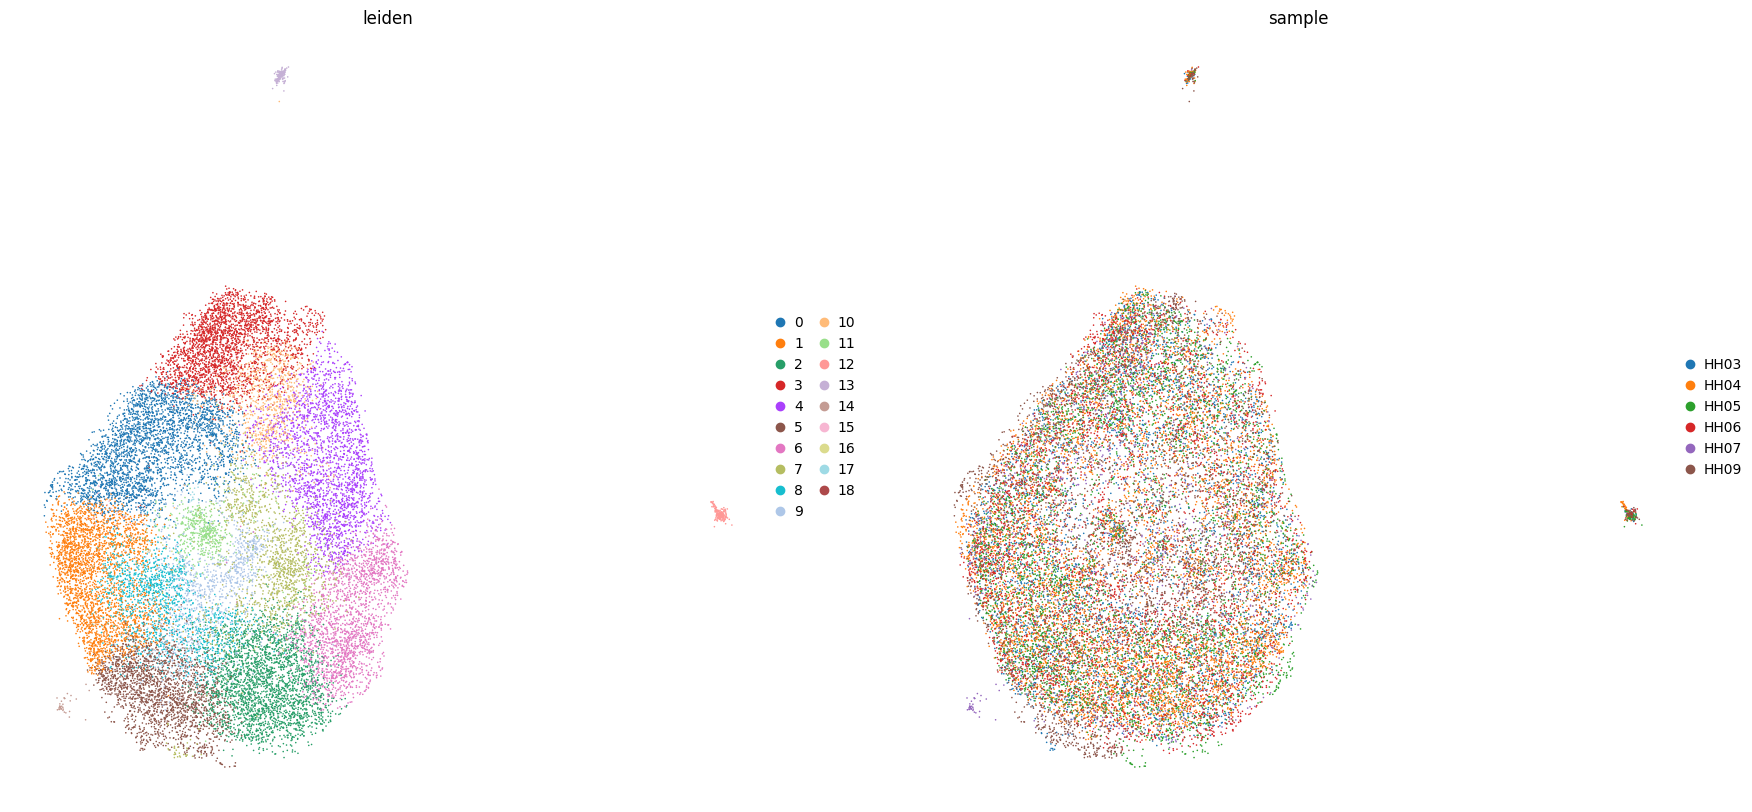

CPU times: user 1.38 s, sys: 132 ms, total: 1.51 s
Wall time: 1.28 s


In [12]:
%%time

self.cluster(**kws_cluster)
self.plot_umap(["leiden", self._columns["col_sample_id"]])

#### DEGs

                   scores  logfoldchanges          pvals      pvals_adj  \
leiden names                                                              
0      CD74     40.566200        1.307007   0.000000e+00   0.000000e+00   
       HLA-DRA  40.449886        1.609092   0.000000e+00   0.000000e+00   
       HIF1A    35.524391        1.250521  2.065781e-276  4.200535e-273   

                pct_nz_group  pct_nz_reference  n_cells  
leiden names                                             
0      CD74         0.966361          0.914283     2943  
       HLA-DRA      0.928644          0.822573     2943  
       HIF1A        0.840639          0.665643     2943  
                  scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
leiden names                                                               
1      TMSB4X  39.226757        0.588031    0.0        0.0      0.999623   
       LYZ     38.741131        0.948746    0.0        0.0      0.999623   
       CD74    37.763618      

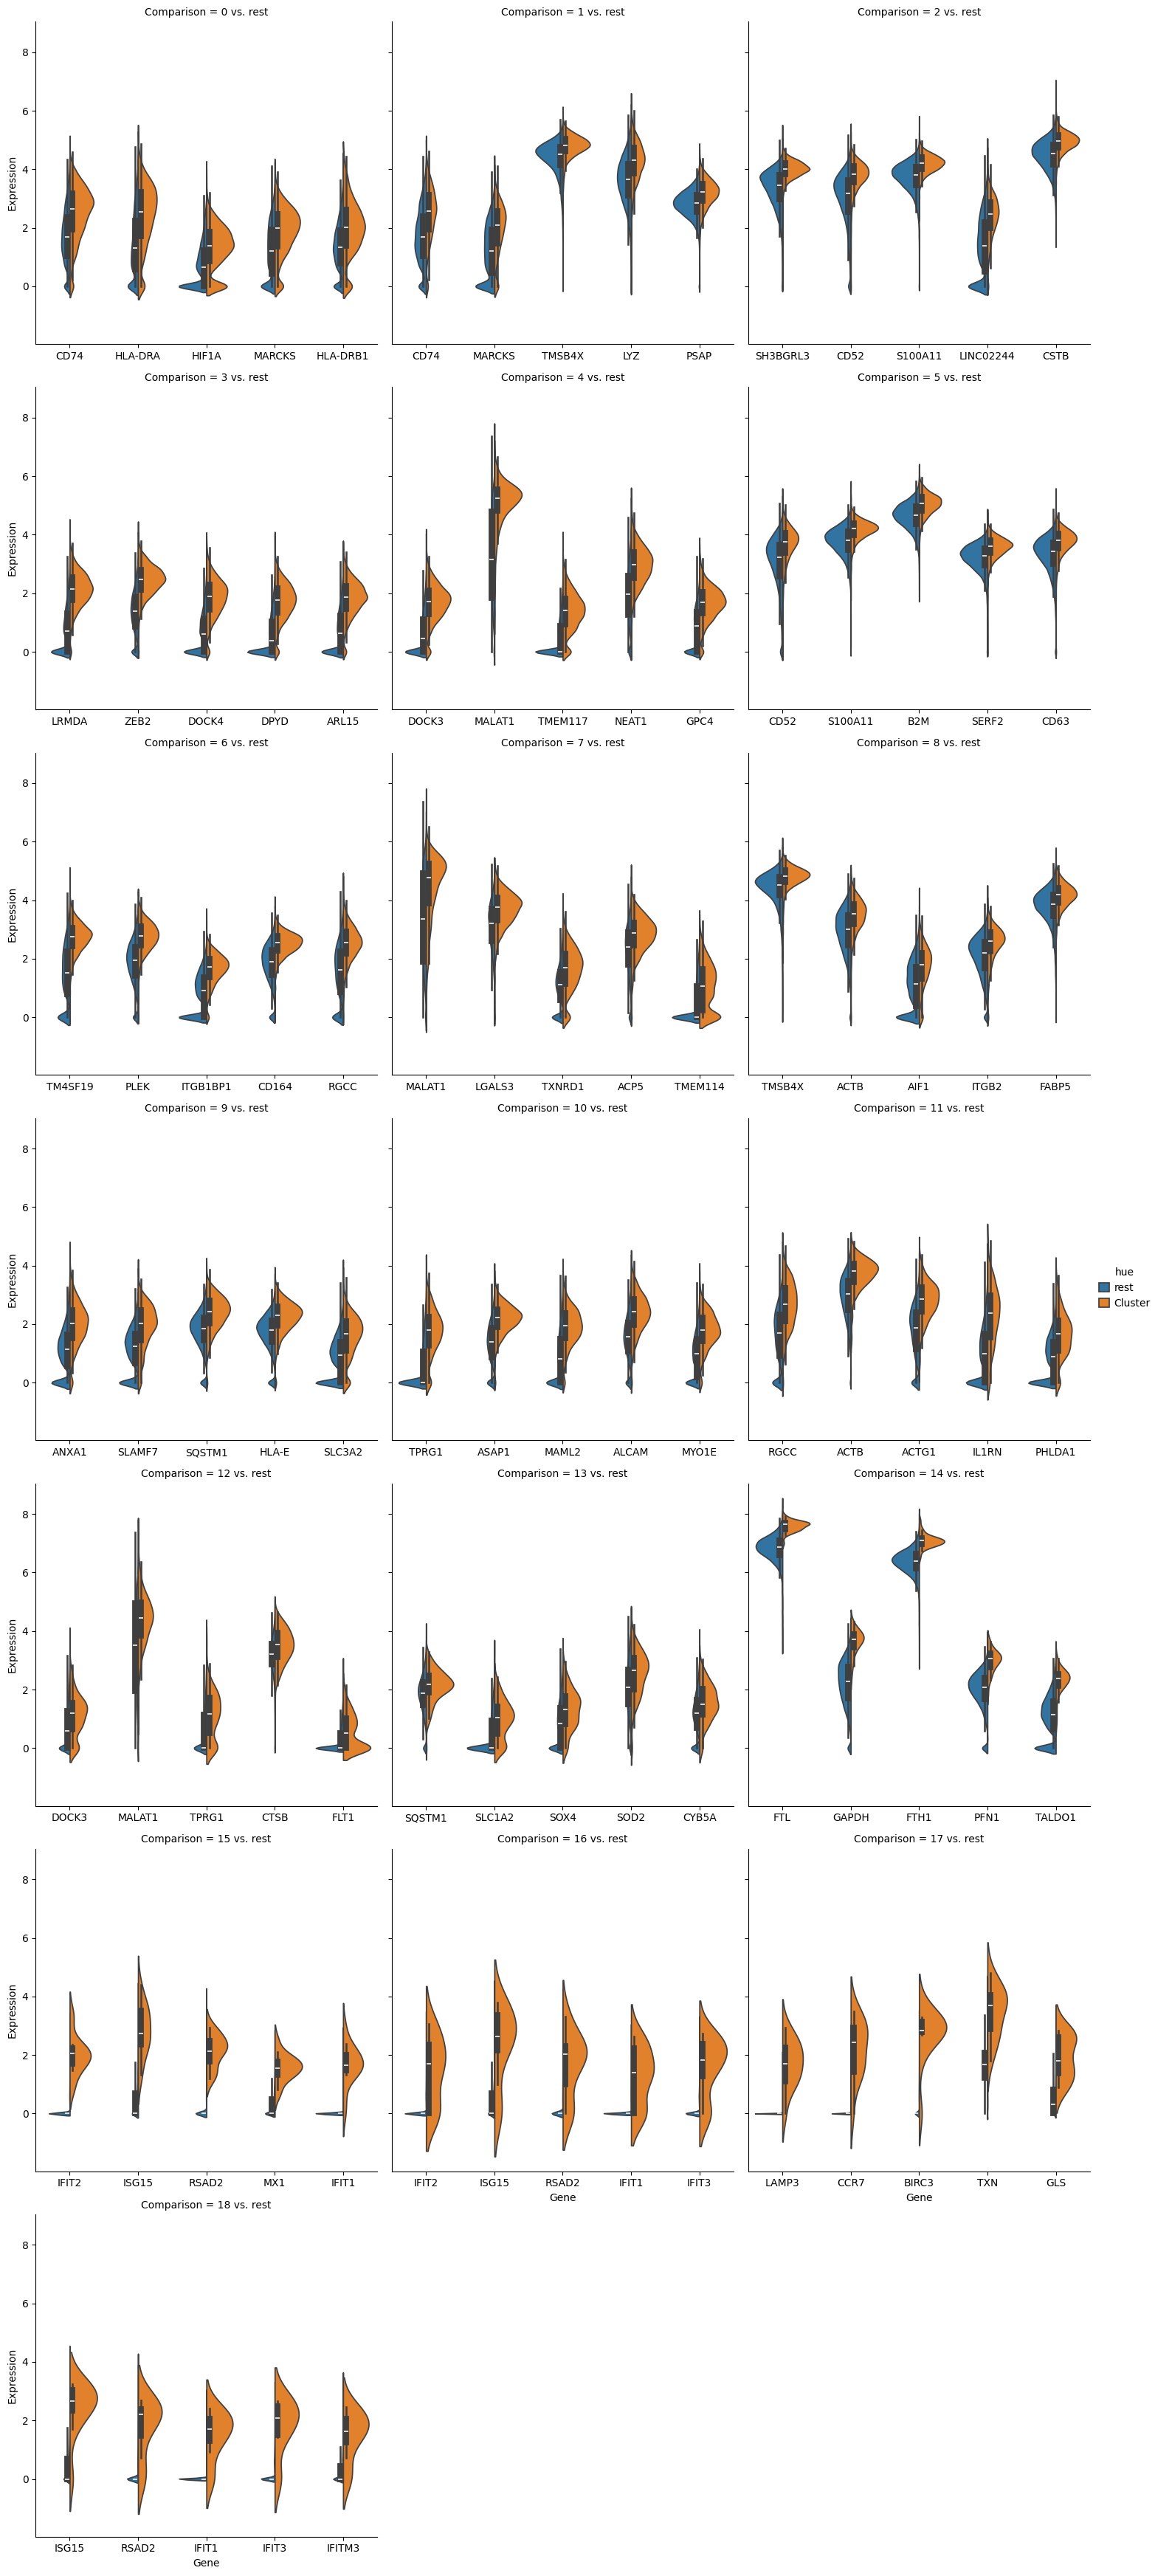

In [13]:
%%time

marks, figs_m = self.find_markers()  # DEGs/cluster markers

## Annotations

### Elmentaite Marker-Based

    CLC+ Mast cell  LYVE1+ Macrophage  MMP9+ Inflammatory macrophage  \
0              0.0                2.0                            1.0   
1              0.0                0.0                            2.0   
2              0.0                0.0                            0.0   
3              0.0                0.0                            0.0   
4              0.0                0.0                            0.0   
5              0.0                0.0                            2.0   
6              0.0                0.0                            0.0   
7              0.0                0.0                            1.0   
8              0.0                1.0                            1.0   
9              0.0                0.0                            0.0   
10             0.0                0.0                            0.0   
11             1.0                1.0                            0.0   
12             0.0                0.0                           

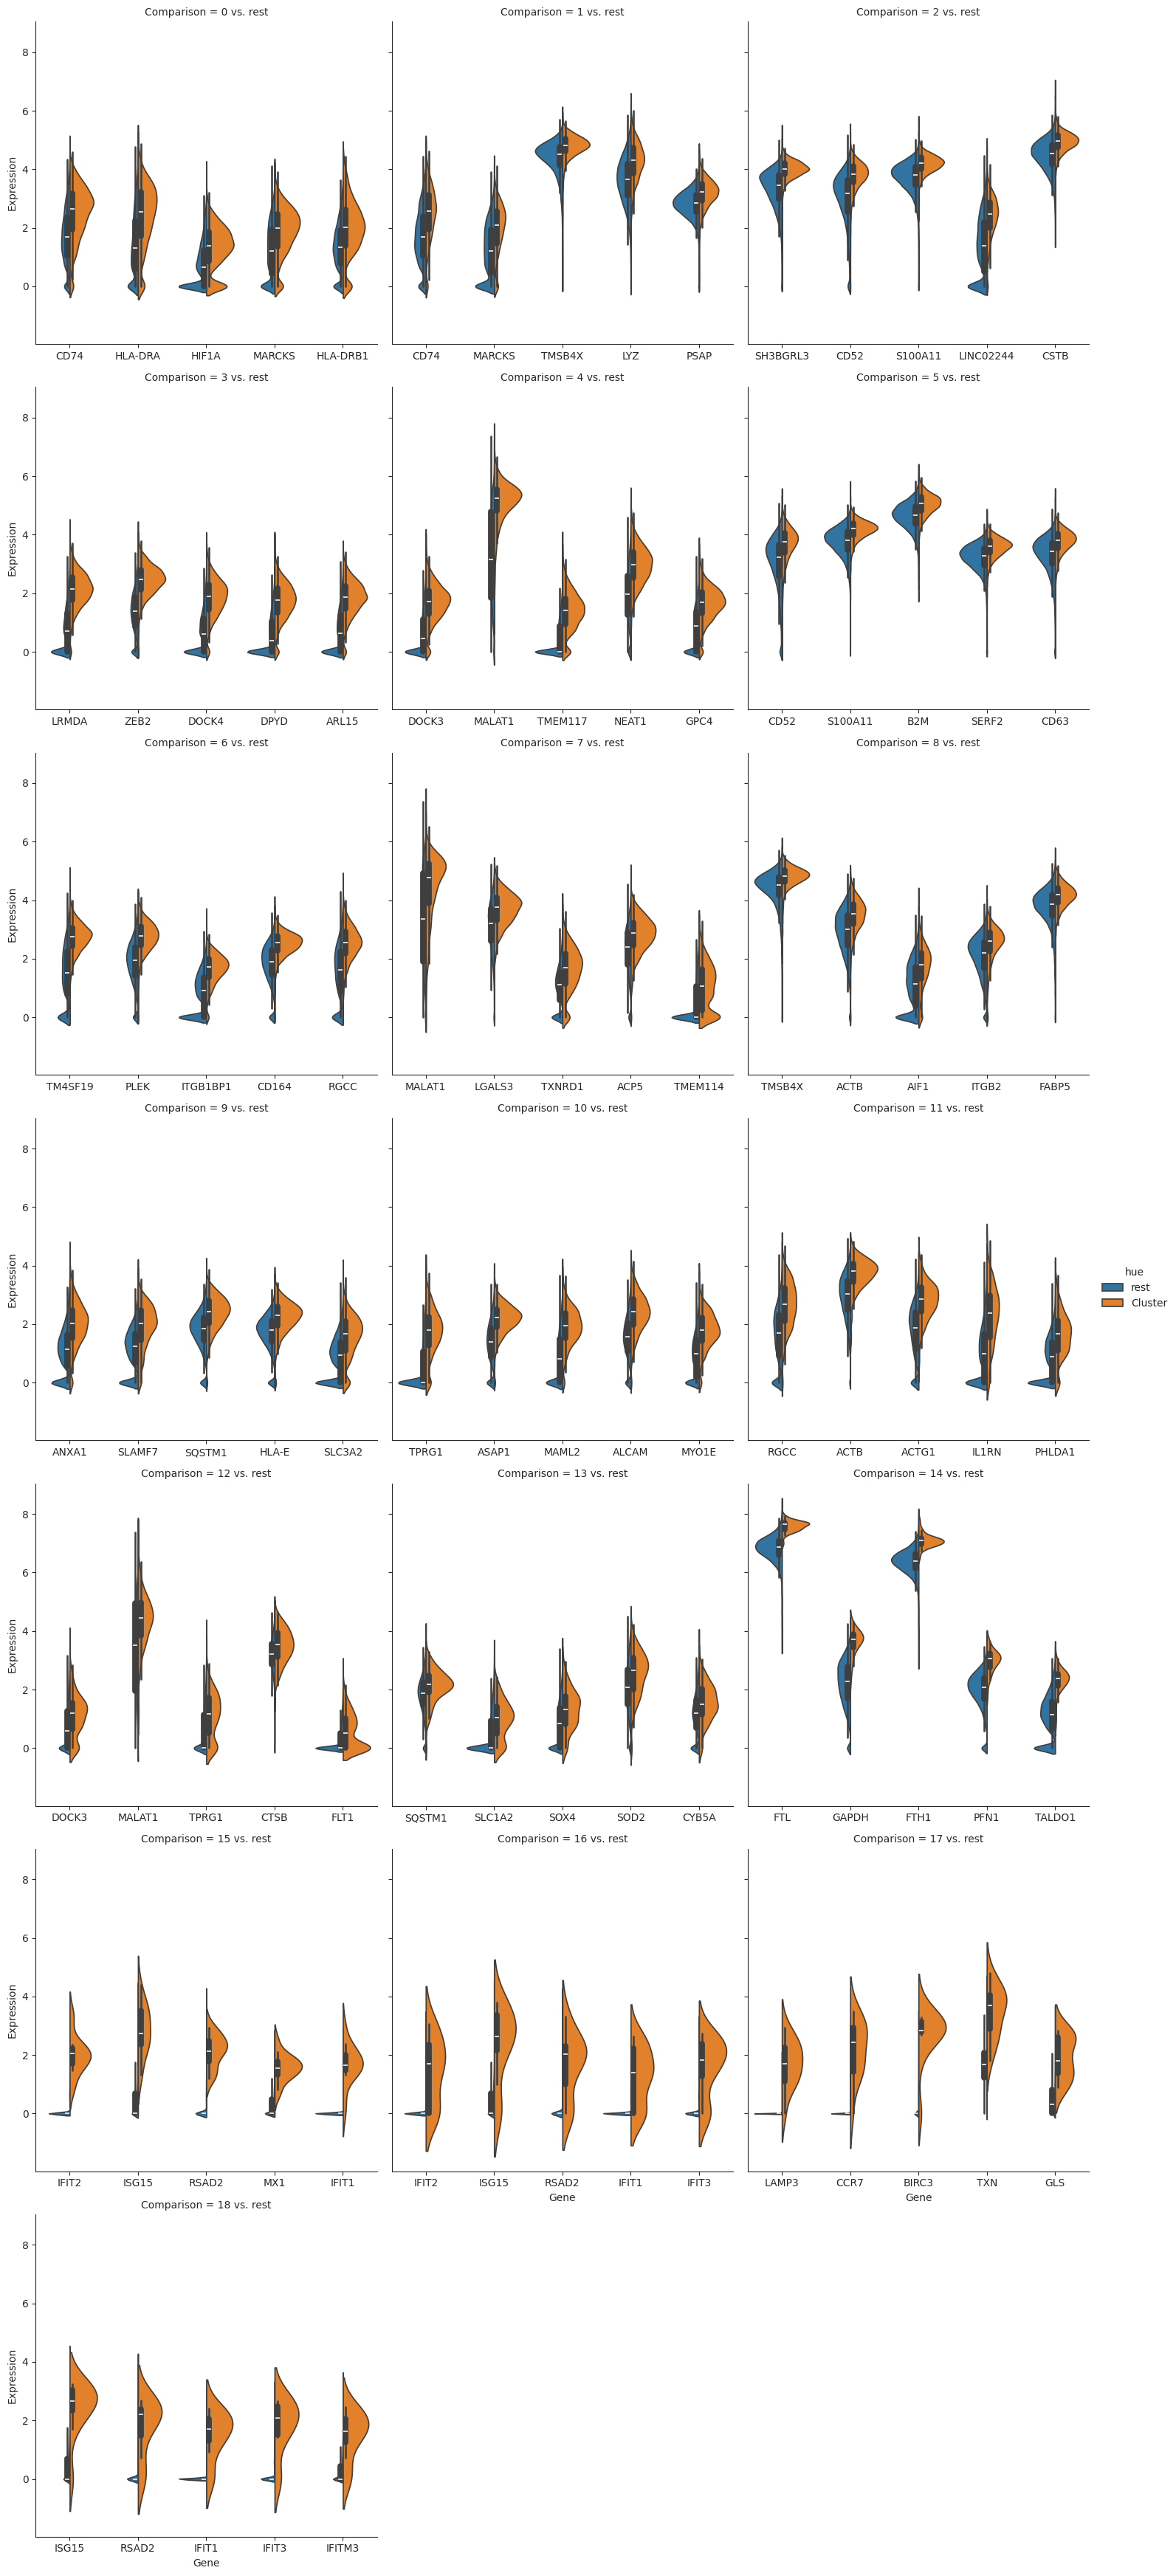

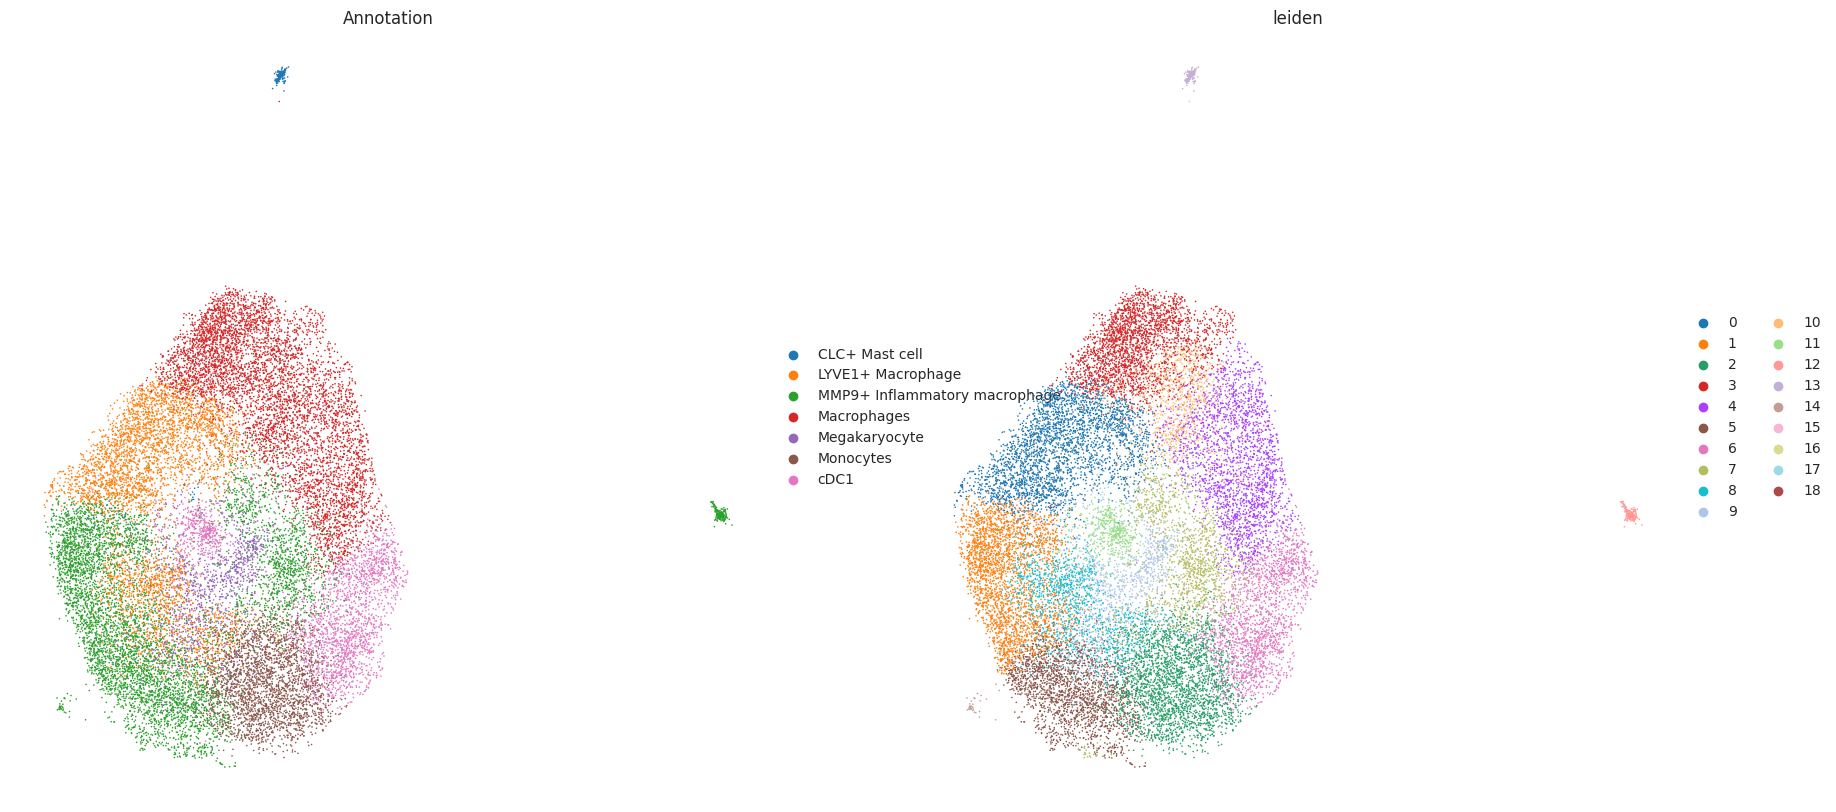

In [12]:
assign = pd.read_csv(file_ann, index_col=0)
if keys_marker_cell_types is not None:
    assign = assign[assign.Lump.isin(keys_marker_cell_types)]
_, out_elmentaite = self.annotate_clusters(assign[[col_annotation]],
                                           col_annotation=col_annotation)

### CellTypist

👉 Detailed model information can be found at `https://www.celltypist.org/models`
🔬 Input data has 22799 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


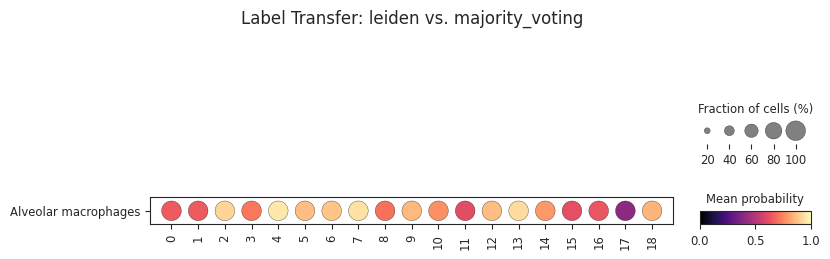

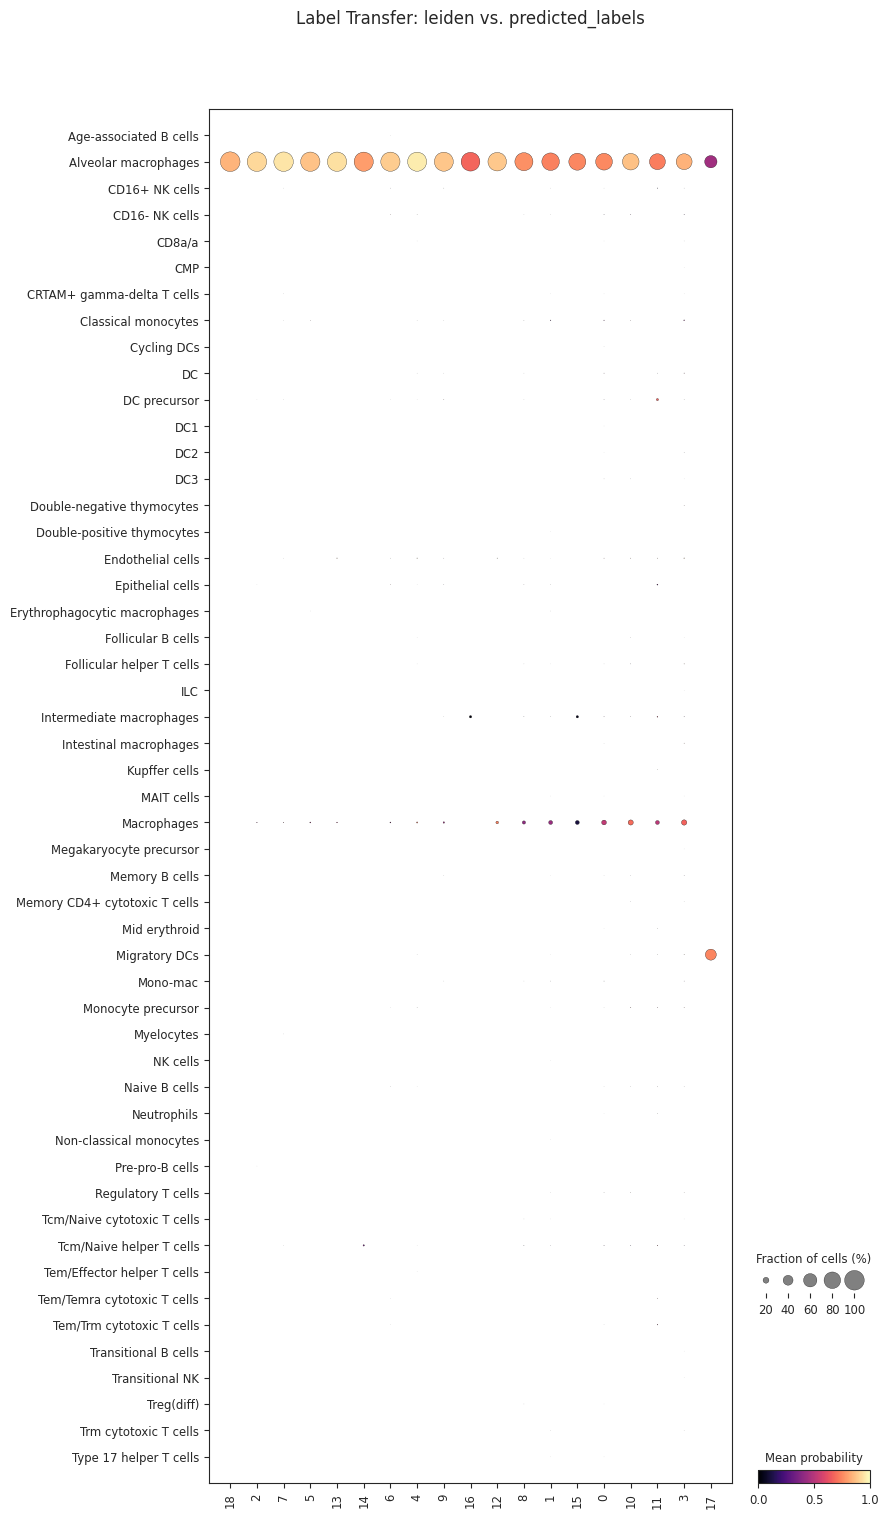

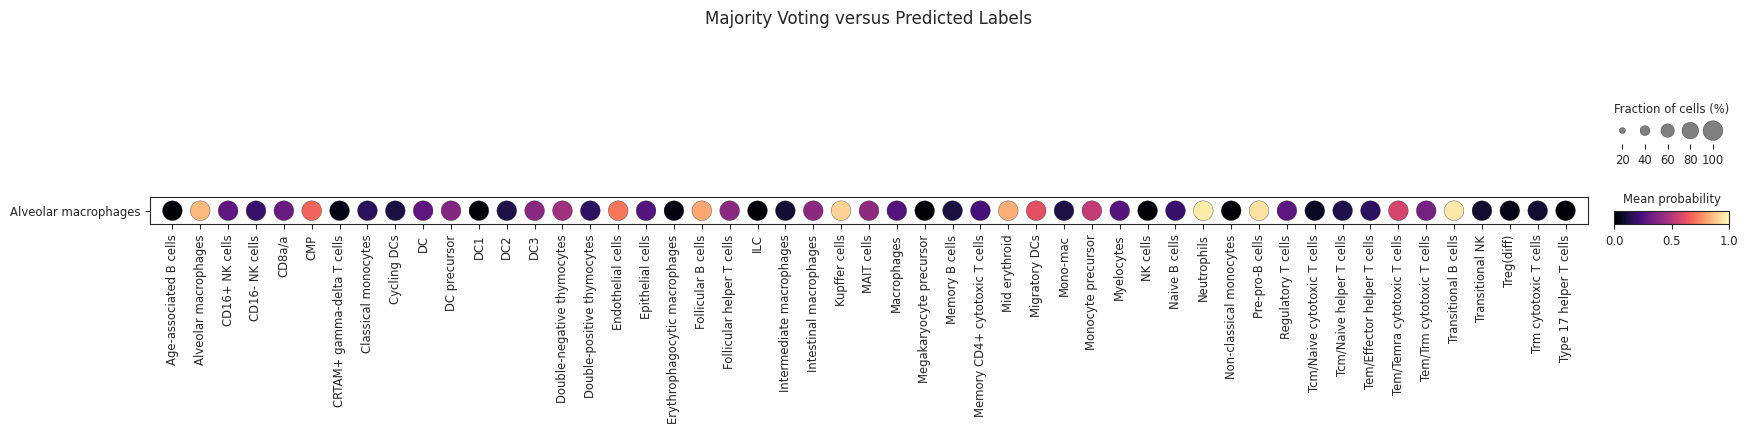

AnnData object with n_obs × n_vars = 22799 × 36601
    obs: 'MDP', 'Oxia', 'feature_call', 'feature_call_processed', 'feature_split', 'guide_split', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'log_counts', 'n_genes', 'n_genes_by_counts', 'n_obs_raw', 'num_features', 'num_umis', 'num_umis_original', 'num_umis_processed', 'percent_umis', 'perturbation', 'perturbed', 'sample', 'target_gene', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'total_umis_cell', 'pct_counts_mt', 'pct_counts_ribo', 'n_counts', 'outlier_pct_counts_mt_threshold', 'outlier_pct_counts_ribo_threshold', 'outlier_n_counts_threshold', 'outlier', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_target_genes', 'col_perturbed', 'col_guide_rna', 'col_guide_split', 'kws_hvg', 'target_sum', 'regress_out', 'outlier_mads', 'cell_filter_ngene', 'gene_filter_n_cell', 'kws_scale

[CellTypist prediction result for 22799 query cells
     predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
     decision_matrix: data frame with 22799 query cells and 98 cell types
     probability_matrix: data frame with 22799 query cells and 98 cell types
     adata: AnnData object referred,
 {'label_transfer_majority_voting': None,
  'label_transfer_predicted_labels': None,
  'label_transfer_mv_pl': None,
  'all': <Figure size 2048x480 with 2 Axes>,
  'confidence': <seaborn.axisgrid.FacetGrid at 0x7f6ed9718b20>}]

In [20]:
_, out_celltypist = self.annotate_clusters(model_celltypist)
out_celltypist

## Set Default Cell Type Column

This process allows you not to have to manually specify the `col_cell_type` arguments in downstream methods.

You also could have done this part originally above where you loaded the object with `cr.Spatial()` (e.g., `cr.Spatial(os.path.join(dir_data, file_path), col_cell_type="lump_res1pt5_dist0_npc30", library_id=lib)`).

You can always change it later just like in the cell below if you want to change the default going forward.

If you want to change it just for one method/function call, just specify the `col_cell_type` argument (e.g., if `self._columns["col_cell_type"]` is "lump_res1pt5_dist0_npc30" and you want to plot the Leiden clusters, run `self.plot_spatial(col_cell_type="leiden_res1pt5_dist0_npc30")` instead of just `self.plot_spatial()`).

Currently, it's set to the Leiden clusters. Change it to the CellTypist annotations? (You could also specify any of the other automatic or manual annotation columns if you choose.)

In [ ]:
self._columns["col_cell_type"] = col_annotation
# self._columns["col_cell_type"] = "majority_voting"
# self._columns["col_cell_type"] = "predicted_labels"

## Gene Expression Plots


<<< PLOTTING GEX (Heatmap) >>>

<<< PLOTTING GEX (Dot) >>>


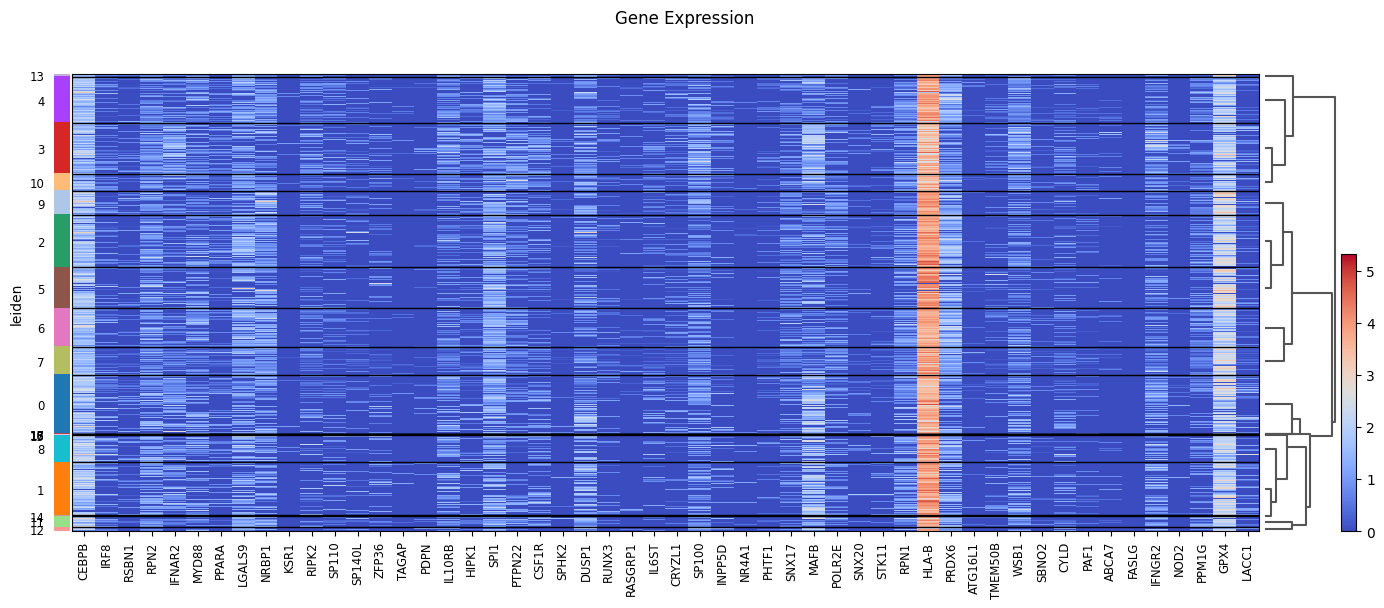

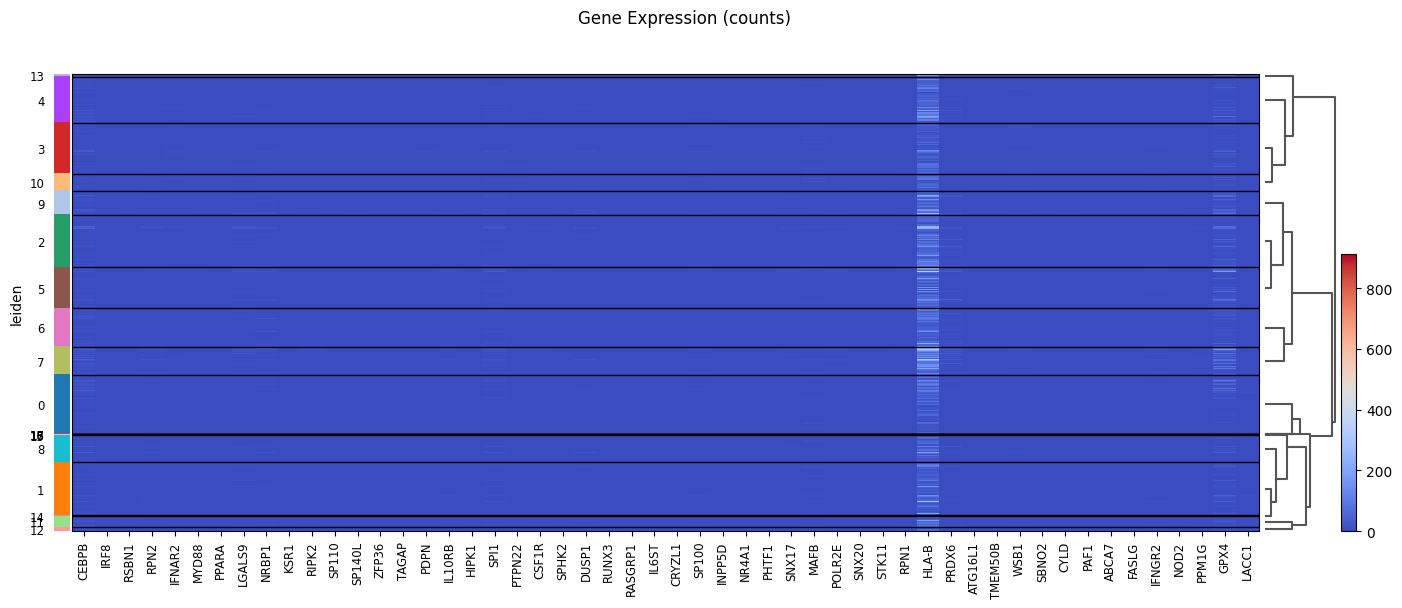

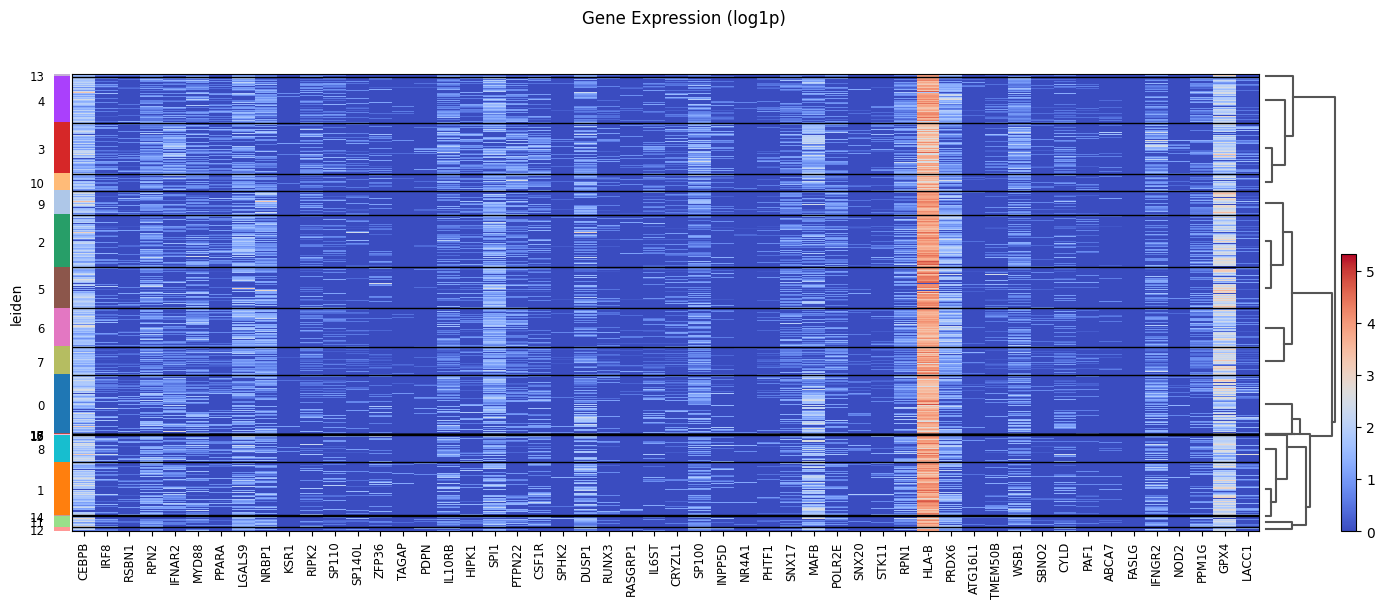

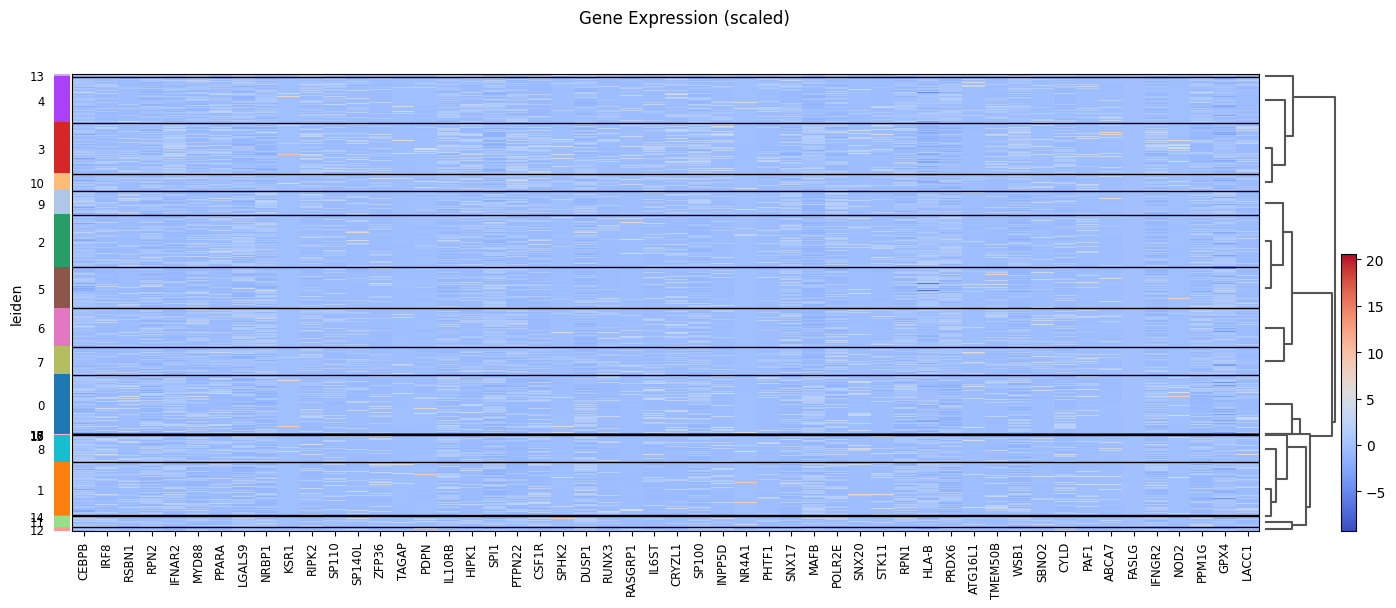

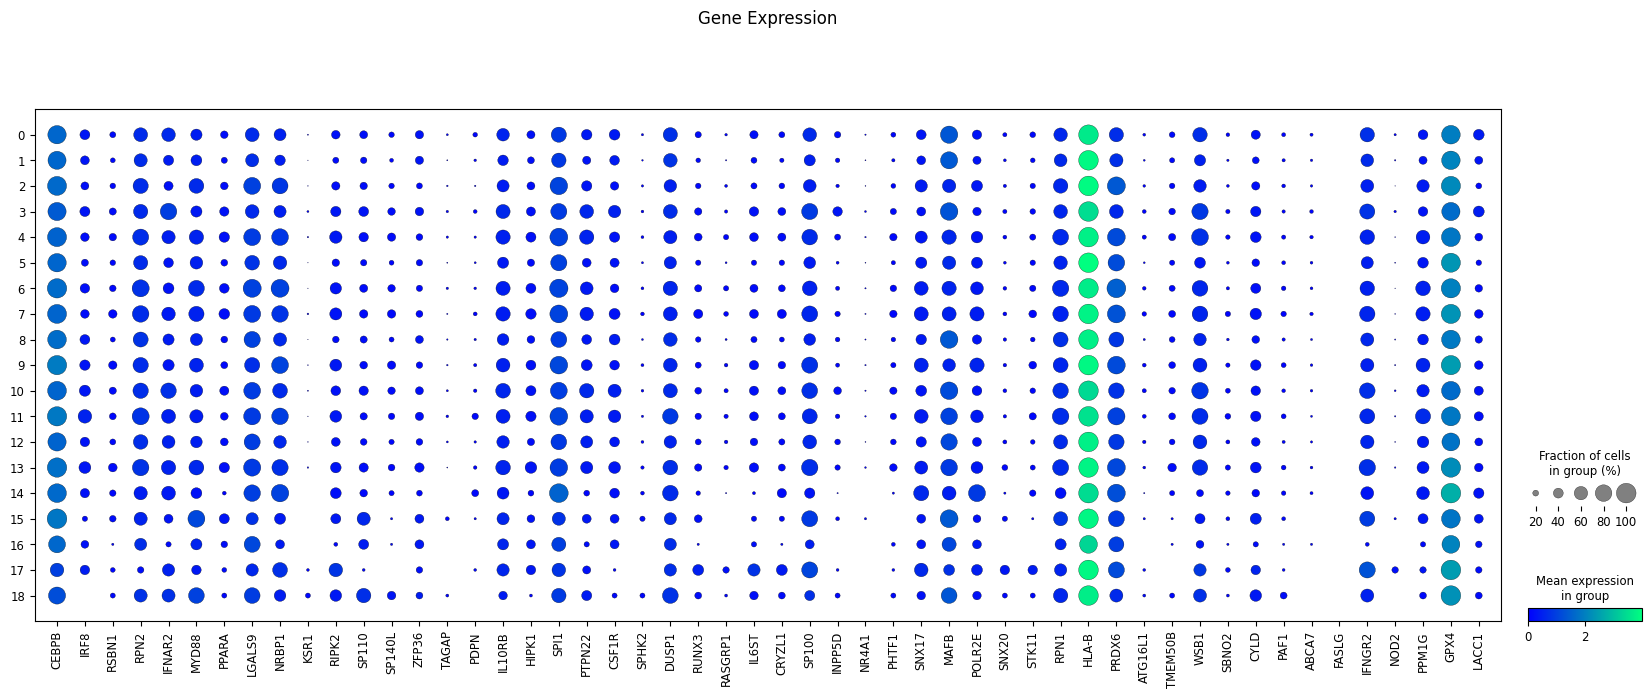

{'gex': {'heat': (<Figure size 1680x600 with 4 Axes>,
   {'heatmap_ax': <Axes: >,
    'groupby_ax': <Axes: ylabel='leiden'>,
    'dendrogram_ax': <Axes: >}),
  'heat_counts': (<Figure size 1680x600 with 4 Axes>,
   {'heatmap_ax': <Axes: >,
    'groupby_ax': <Axes: ylabel='leiden'>,
    'dendrogram_ax': <Axes: >}),
  'heat_log1p': (<Figure size 1680x600 with 4 Axes>,
   {'heatmap_ax': <Axes: >,
    'groupby_ax': <Axes: ylabel='leiden'>,
    'dendrogram_ax': <Axes: >}),
  'heat_scaled': (<Figure size 1680x600 with 4 Axes>,
   {'heatmap_ax': <Axes: >,
    'groupby_ax': <Axes: ylabel='leiden'>,
    'dendrogram_ax': <Axes: >}),
  'dot': <scanpy.plotting._dotplot.DotPlot at 0x7fdcdc20ba00>}}

In [15]:
self.plot(self.adata.obs[self._columns["col_target_genes"]].unique(),
          kind=["heat", "dot"])

## Analyses

Perform downstream CRISPR analyses.

Remember that parameters like `col_cell_type`, `col_condition`, `col_perturbed`, `col_target_genes`, `key_treatment`, and `key_control` are, by default, pulled from `self._columns` and `self._keys`; however, you can override the defaults by passing the appropriate arguments to the methods below (e.g., `self.run_augur(col_cell_type="leiden", ...)`)

### Targeting Efficiency

This example calculates targeting efficiency for each target versus all other perturbations and control. 

**You can specify any list of perturbations to use as a reference group** by passing the argument `key_compare`. Thus, to use just control as a reference group, use the following code:
```python
targ_eff = self.calculate_targeting_efficiency(
    key_compare=[self._keys["key_control"]], plot=False)
```

**To compare both methods, see code in the following dropdown.**

<details>
  <summary>Reference Group Comparison</summary>

  ```python
kde_a = self.calculate_targeting_efficiency(plot=False)
kde_c = self.calculate_targeting_efficiency(
    key_compare=[self._keys["key_control"]], plot=False)  # versus control
kde = pd.concat([kde_a, kde_c], keys=[
    "Versus All Other", "Versus Control"], names=["Reference Group"])
print(kde["Targeting Efficiency"].groupby("Reference Group").describe())
fig = sb.catplot(kde, x=self._columns["col_condition"],
                 y="Targeting Efficiency", hue="Reference Group",
                 height=20, kind="bar")
fig.fig.suptitle("Targeting Efficiency")
fig.set_xticklabels(rotation=90)
  ```

</details>

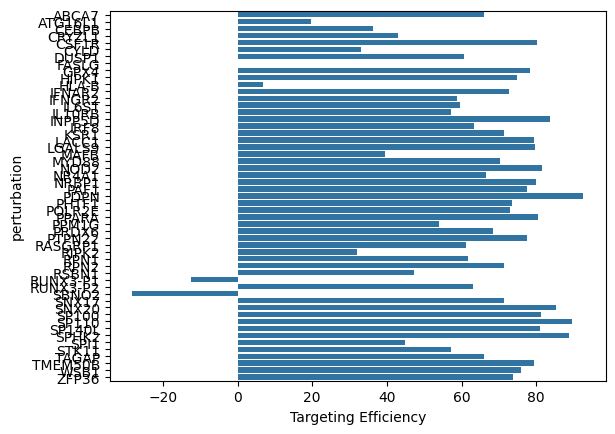

In [14]:
targ_eff = self.calculate_targeting_efficiency()

### Distance

Compute distance scores comparing gene expression profiles across perturbation conditions.

In [16]:
%%time

cct = "Annotation"
dist = "mmd"
# dist = "edistance"
_ = self.compute_distance(distance_type=dist, method="X_pca", kws_plot=dict(
    figsize=(15, 15), robust=True), col_cell_type=cct)

Output()

Output()

Output()

### Augur

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type
- Identify the most important features (genes).

<u> __Input__ </u>  

There are no required arguments. 
* If you want to override defaults drawn from `._columns` and/or `._keys`, specify the appropriate argument (e.g., `col_cell_type`). 
* You can also specify a different `classifer` (default "random_forest_classifer") used in the machine learning classification procedure used to calculate the AUCs/accuracy. 
* You may pass keyword arguments to the Augur predict method by specifying a dictionary in `kws_augur_predict`.
* Specify `select_variance_features` as True to run the original Augur implementation, which removes genes that don't vary much across cell type. If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
* Specify `n_folds` and/or `subsample_size` to choose the number and sample size of folds in cross-validation.
* Set an integer for `seed` to allow reproducibility across runs.

<u> __Output__ </u>  

Tuple, where the first element is the AnnData object created by the function, the second, the results dictionary, and the third, a dictionary of figures visualizing results. If `copy=False`, results are stored in `self.rna.uns["augurpy_results"]` and scores are stored in `self.rna.obs["augur_score"]`

<u> __Notes__ </u>  

- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - `select_variance_feature=True`
    - If `False`, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.

In [ ]:
%%time

# cct = "Annotation" if "Annotation" in self.rna.obs else None
# adata_augur, res_augur, figs_augur = self.run_augur(
#     select_variance_features=True,  # filter by highly variable genes
#     classifier="random_forest_classifier", n_folds=3, augur_mode="default",
#     kws_umap=kws_cluster["kws_umap"], subsample_size=10,
#     kws_augur_predict=dict(span=0.7), n_jobs=12)

### Mixscape

**Is a perturbed cell detectibly perturbed, and to what extent?** Mixscape first calculates the "**perturbation signature**" by determining which control condition cells most closely resemble each perturbed cell in terms of mRNA expression and then subtracts the control expression from that of the perturbed cells' (i.e., centers perturbed cells' gene expression on their control neighbors).

Then, it **identifies** and removes perturbed **cells with no detectible perturbation** (i.e., assigns them to predicted classes of perturbed versus not perturbed). You can then create visuals based on whether the cell is detectibly perturbed, "non-perturbed" (not detectibly perturbed), or control (no treatment). Optionally, you can visualize protein expression by this predicted class in certain multi-modal data.

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_ 

<u> __Features__ </u>  

- Plot targeting efficiency.
- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

If you want to `re-create mixscape plots` **with <u> different target genes and/or proteins of interest**</u> later, you can use `self.plot_mixscape(<ONE OR MORE TARGET GENES>)` without having to re-run Mixscape. If you want a different color for the perturbation score curves, specify `color=` in that method.

```python
_ = self.plot_mixscape(new_list_of_genes, color="red")
```

<u> __Input__ </u> 

See documentation, but the key arguments are listed here.

* **col_cell_type**: If you want to run using a different cell classification column, (e.g., CellTypist annotations that weren't used for the original `self._columns["col_cell_type"]`), you can specify a different column by passing `col_cell_type=<column name>`.
* **target_gene_idents**: A list of gene symbols to focus on in plots/analyses. Specify as True to include all.
* **target_gene_idents**: The default layer of data used is "log1p." Remember that Mixscape centers cells on their control neighbors when considering whether to use centered and/or scaled data.

<u> __Output__ </u>  

Assuming your `Crispr` object is named "self":
- Targeting Efficiency: `self.figures["mixscape"]["targeting_efficiency"]`
- Differential Expression Ordered by Posterior Probabilities: `self.figures["mixscape"]["DEX_ordered_by_ppp_heat"]`
- Posterior Probabilities Violin Plot: `self.figures["mixscape"]["ppp_violin"]`
- Perturbation Scores: `self.figures["mixscape"]["perturbation_score"]`
- Perturbation Clusters (from LDA): `self.figures["mixscape"]["perturbation_clusters"]`

The above instructions are for accessing output via the object attributes. Assuming output is assigned to a variable `figs` (i.e., `figs = ` would replace the `_ = ` in the code below), replace `self.figures["mixscape"]` in the above code with `figs`.

<u> __Notes__ </u>  

- If `._columns["col_sample_id"]` is not None, perturbation scores will by default be calculated and/or plotted taking that into consideration (e.g., biological replicates) unless `col_split_by=False`. That argument can also be set to a different column name explicitly, in which case that specification will be used as the `col_split_by` argument in Pertpy Mixscape functions in place of sample ID.

In [ ]:
%%time

cct = "Annotation" if "Annotation" in self.rna.obs else None
tgis = list(self.rna.obs[self._columns["col_target_genes"]].sample(3))
_, figs_mix = self.run_mixscape(col_cell_type=cct, target_gene_idents=tgis)

### Multi-Cellular Programs

Find multi-cellular programs using Dialogue.

In [ ]:
%%time

cct = "Annotation" if "Annotation" in self.rna.obs else None
fig_mcp = self.run_dialogue(n_programs=3, cmap="coolwarm", col_cell_type=cct,
                            col_condition=self._columns["col_target_genes"])